<a href="https://colab.research.google.com/github/ufbfung/cardiac-3d-reconstruction/blob/main/3d_reconstruction_left_ventricle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In this section, we'll setup our environment to run a 3d reconstruction algorithm. Some assumptions we will make are:
- We have a list of A4C and PSAX pairs
- We have "ground truth" labels for each A4C and PSAX pair to allow for evaluation of ejection fraction (EF)
- We have segmented images (or label tracings) that will allow us to calculate the 3d reconstruction of the left ventricle

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import relevant libraries
import os # to deal with file paths
import numpy as np # to deal with data
import pandas as pd # to deal with data
import cv2 # to read videos
from matplotlib import pyplot as plt # to plot figures

In [3]:
# File paths
root_path = '/content/drive/My Drive/Stanford/biomedin260/data/final_project/pediatric_echo_avi/pediatric_echo_avi'

a4c_path = os.path.join(root_path, 'A4C')
a4c_videos_path = os.path.join(a4c_path, 'Videos')
a4c_filelist_path = os.path.join(a4c_path, 'FileList.csv')
a4c_volumetracings_path = os.path.join(a4c_path, 'VolumeTracings.csv')

psax_path = os.path.join(root_path, 'PSAX')
psax_videos_path = os.path.join(psax_path, 'Videos')
psax_filelist_path = os.path.join(psax_path, 'FileList.csv')
psax_volumetracings_path = os.path.join(psax_path, 'VolumeTracings.csv')

merged_views_path = os.path.join(root_path, 'merged_a4c_psax_views.csv')

In [4]:
# Useful constants
COLUMN_FRAME = 'Frame' # Column name for the frame number in the Volume Tracing File.
COLUMN_FILE_NAME = 'FileName' # Column name for File name in both the FileList and Volume Tracing files.
COLUMN_X = 'X' # Column name for the X coordinate of the labelled frame in the Volume Tracing File.
COLUMN_Y = 'Y' # Column name for the Y coordinate of the labelled frame in the Volume Tracing File.

In [5]:
# Echocardiogram videos
# Per https://echonet.github.io/pediatric/
# there should be 3,176 apical-4-chamber echocardiography videos and
# 4,424 parasternal short axis echocardiography videos from individuals
# who underwent imaging between 2014 - 2021 as part of routine clinical care at Lucile Packard Children's Hospital at Stanford

# Downloaded videos appear to contain more
len_a4c_videos = len(os.listdir(psax_videos_path))
len_psax_videos = len(os.listdir(a4c_videos_path))

print("count of a4c videos:", len_a4c_videos)
print("count of psax videos:", len_psax_videos)

count of a4c videos: 4526
count of psax videos: 3284


# Data Pre-processing

## Merge A4C and PSAX Views

In the EchoNet Pediatric dataset, there is no unique identifier that links the A4C and PSAX views. To join the two views into a single row, a match was made using "EF", "Weight", and "Height" and create a unique ID for each patient using a combination of "EF", "Sex", "Age", "Weight", "Height", and "Split". The merged dataset is outputted as a csv called merged_a4c_psax_views.csv.

**Details from Yan**:

I noticed that the FileName from the A4C data and the FileName from the PSAX do not match at all. All FileNames are unique. Hence, the way I merge the two data set is using unique record of patient information ("EF", "Sex", "Age", "Weight", "Height", "Split") since the measurement of "EF", "Weight", "Height" have higher precision (two decimals), hence I will use a combination of all patient information as the unique ID to guide the merge.

Some of the merging details are as the following:
- In A4C there are 3284 patients, 3,176 are unique records (unique w.r.t patient information), hence all the patients with duplicated patient information are removed from the matching.
- In PSAX there are 4526 patients, 4,282 are unique records, hence all the patients with duplicates are also removed.
- After merging the two FileList, we arrive at 3,133 common records. I then look into how many frames are used for annotating each record in A4C and PSAX, and how many coordinates are included.

In the merged dataframe, you will find the following variables:
- "FileName_PSAX" : file name from PSAX for this patient (string)
- "FileName_A4C" :  file name from A4C for this patient (string)
- "EF" : ejection fraction (numeric)
- "Sex" : sex (string, M, F)
- "Age" : age (numeric, 0 - 18)
- "Weight": weight (numeric)
- "Height" : height (numeric)
- "Split" :   I don't know what is this for yet (numeric, 0 - 9)
- "Total_Num_Points_A4C" : total number of points annotated in A4C (numeric)
- "Num_Frame_A4C" : total number of frames included in A4C (numeric)
- "Total_Num_Points_PSAX" : total number of points annotated in PSAX (numeric)
- "Num_Frame_PSAX" : total number of frames included in PSAX (numeric)

In [6]:
# Import merged_views csv and view first 5 rows

merged_views = pd.read_csv(merged_views_path)
merged_views.head()

,PatientNumber,FileName_PSAX,FileName_A4C,EF,Sex,Age,Weight,Height,Split,Total_Num_Points_A4C,Num_Frame_A4C,Total_Num_Points_PSAX,Num_Frame_PSAX
0,1,CR32a7555-CR32a7582-000027.avi,CR32a7555-CR32a7582-000039.avi,40.83,F,0,10.2,68.5,5,190,2,108,2
1,2,CR32a7555-CR32a97af-000030.avi,CR32a7555-CR32a97af-000033.avi,52.62,F,1,15.5,85.0,5,51,2,71,2
2,3,CR32a7555-CR32a97e1-000009.avi,CR32a7555-CR32a97e1-000024.avi,24.85,F,0,4.0,56.0,5,38,2,33,2
3,4,CR32a7555-CR32a9850-000035.avi,CR32a7555-CR32a9850-000040.avi,50.96,F,4,18.0,99.0,5,33,2,41,2
4,5,CR32a7555-CR32a988d-000025.avi,CR32a7555-CR32a988d-000034.avi,56.76,F,0,13.2,75.0,5,839,2,591,2


## Load Volume Tracings

In [7]:
# Load a4c volume tracings
a4c_volume_tracings = pd.read_csv(a4c_volumetracings_path)

# Load psax volume tracings
psax_volume_tracings = pd.read_csv(psax_volumetracings_path)

## Define Helper Functions to Process Videos & Segment using Volume Tracings

In [8]:
# Define helper functions to navigate data

def extract_filenames_using_patientid(df, patient_id):
    filenames_psax = df.loc[df['PatientNumber'] == patient_id, 'FileName_PSAX'].tolist()
    filenames_a4c = df.loc[df['PatientNumber'] == patient_id, 'FileName_A4C'].tolist()

    for psax_filename in filenames_psax:
        print(f"PSAX filename: {psax_filename}")
        display_psax_labels(psax_filename)

    for a4c_filename in filenames_a4c:
        print(f"A4C filename: {a4c_filename}")
        display_a4c_labels(a4c_filename)

def read_video(path):
  frames = []
  cap = cv2.VideoCapture(path)
  ret = True
  while ret:
    ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
    if ret:
      frames.append(img)
  video = np.stack(frames, axis=0) # dimensions (Time, Height, Width, Channels)
  return video

def read_a4c_video(file_name):
  return read_video(os.path.join(a4c_videos_path, file_name))

def read_psax_video(file_name):
  return read_video(os.path.join(psax_videos_path, file_name))

def display_video(vol, title=""):
  n_slices = vol.shape[0]
  row_plots = 5;
  col_plots = 5;
  delta = int(n_slices/(row_plots*col_plots))
  fig,ax = plt.subplots(5,5, figsize = (10,10))
  fig.suptitle(title, fontsize=16)
  for row in range(row_plots):
    for col in range(col_plots):
      slide_n = (delta*col)+row*delta*row_plots
      ax[row,col].imshow(vol[slide_n,:,:,:])
      ax[row,col].axis('off')
      ax[row,col].title.set_text('Frame #' + str(slide_n))

def display_labels(df, video, file_name, view):
    # A video will typically have 2 frames labelled, so go through all the frames,
    # and display their labels.
    num_frames = len(df[COLUMN_FRAME].unique())
    cols = 2  # Number of columns to display the plots horizontally
    rows = (num_frames - 1) // cols + 1  # Number of rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    fig.suptitle(f'File: {file_name}', fontsize=16)

    plt.subplots_adjust(wspace=0.005)  # Adjust the horizontal spacing between subplots

    for i, frame_idx in enumerate(df[COLUMN_FRAME].unique()):
        group_df = df.groupby([COLUMN_FRAME]).get_group(frame_idx)
        img_slide = video[int(frame_idx), :, :, :]

        ax = axs[i // cols, i % cols] if rows > 1 else axs[i % cols]
        ax.imshow(img_slide)  # Display original image

        # Create an array with the tracing points
        x = group_df[COLUMN_X].values
        y = group_df[COLUMN_Y].values
        x_y = np.int32(np.array([x, y]).T)

        mask = np.zeros((img_slide.shape[0], img_slide.shape[1], 3), dtype=np.uint8)  # Create empty mask

        if view == 'psax':
            # Fit a circle to the tracing points
            center, radius = cv2.minEnclosingCircle(x_y)
            center = (int(center[0]), int(center[1]))  # Convert center coordinates to integers
            radius = int(radius)  # Convert radius to integer
            diameter = 2 * radius
            cv2.circle(mask, center=center, radius=radius, color=(0, 191, 255), thickness=-1)  # Fill the mask with a circle
            overlay_text = f'Circle\nRadius: {radius:.2f}, Diameter: {diameter:.2f}'

            # Draw the diameter line
            cv2.line(mask, (center[0] - radius, center[1]), (center[0] + radius, center[1]), color=(0, 255, 0), thickness=2)

        elif view == 'a4c':
            # Fit an ellipse to the tracing points
            ellipse_params = cv2.fitEllipse(x_y)
            cv2.ellipse(mask, ellipse_params, color=(0, 191, 255), thickness=-1)  # Fill the mask with an ellipse
            major_axis = max(ellipse_params[1])
            minor_axis = min(ellipse_params[1])
            angle = ellipse_params[2]
            overlay_text = f'Ellipse\nMajor Axis: {major_axis:.2f}, Minor Axis: {minor_axis:.2f}, Angle: {angle:.2f}'

            # Draw major and minor axes
            center, axes, angle = ellipse_params
            major_axis_length = axes[1] / 2
            minor_axis_length = axes[0] / 2
            angle_rad = np.radians(angle)
            cos_angle = np.cos(angle_rad)
            sin_angle = np.sin(angle_rad)
            x_major_start = int(center[0] - major_axis_length * sin_angle)
            y_major_start = int(center[1] + major_axis_length * cos_angle)
            x_major_end = int(center[0] + major_axis_length * sin_angle)
            y_major_end = int(center[1] - major_axis_length * cos_angle)
            x_minor_start = int(center[0] - minor_axis_length * cos_angle)
            y_minor_start = int(center[1] - minor_axis_length * sin_angle)
            x_minor_end = int(center[0] + minor_axis_length * cos_angle)
            y_minor_end = int(center[1] + minor_axis_length * sin_angle)
            cv2.line(mask, (x_major_start, y_major_start), (x_major_end, y_major_end), color=(0, 255, 0), thickness=2)
            cv2.line(mask, (x_minor_start, y_minor_start), (x_minor_end, y_minor_end), color=(0, 255, 0), thickness=2)

        ax.imshow(mask, alpha=0.3)  # Overlay color mask
        ax.scatter(x, y, color='r', alpha=0.5)  # Overlay tracing points

        ax.set_title(f'Frame: {frame_idx}\n{overlay_text}')
        ax.axis('off')

    plt.show()

def display_a4c_labels(file_name):
  df = a4c_volume_tracings[a4c_volume_tracings[COLUMN_FILE_NAME] == file_name]
  video = read_a4c_video(file_name)
  display_labels(df, video, file_name, view='a4c')

def display_psax_labels(file_name):
  df = psax_volume_tracings[psax_volume_tracings[COLUMN_FILE_NAME] == file_name]
  video = read_psax_video(file_name)
  display_labels(df, video, file_name, view='psax')

# Define functions used for 3d reconstruction

In [104]:
# Get volume tracings
def calculate_area(df):
    x = df['X'].values
    y = df['Y'].values
    n = len(x)

    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += (x[i] * y[j]) - (x[j] * y[i])

    area = abs(area) / 2.0
    return area

def get_a4c_volume_tracings(file_name):
    df = a4c_volume_tracings[a4c_volume_tracings[COLUMN_FILE_NAME] == file_name]
    grouped = df.groupby(COLUMN_FRAME)
    areas = grouped.apply(calculate_area)

    end_diastole_frame = areas.idxmax()  # Get the frame with the maximum area as end diastole
    end_systole_frame = areas.idxmin()  # Get the frame with the minimum area as end systole

    end_diastole_df = df[df[COLUMN_FRAME] == end_diastole_frame]  # Filter rows for end of diastole
    end_systole_df = df[df[COLUMN_FRAME] == end_systole_frame]  # Filter rows for end of systole

    # Print information for troubleshooting and validating
    #print("End Diastolic Volume:")
    #print("Area:", areas[end_diastole_frame])
    #print("Frame:", end_diastole_frame)

    #print("\nEnd Systolic Volume:")
    #print("Area:", areas[end_systole_frame])
    #print("Frame:", end_systole_frame)

    # Fit an ellipse to the end diastole volume tracings
    x = end_diastole_df[COLUMN_X].values
    y = end_diastole_df[COLUMN_Y].values
    x_y = np.int32(np.array([x, y]).T)
    ellipse_params = cv2.fitEllipse(x_y)
    major_axis = max(ellipse_params[1])
    minor_axis = min(ellipse_params[1])

    # Print major axis and minor axis values
    print("Major Axis:", major_axis)
    print("Minor Axis:", minor_axis)

    return end_diastole_df, end_systole_df, major_axis, minor_axis

def get_psax_volume_tracings(file_name):
    df = psax_volume_tracings[psax_volume_tracings[COLUMN_FILE_NAME] == file_name]
    grouped = df.groupby(COLUMN_FRAME)
    areas = grouped.apply(calculate_area)

    end_diastole_frame = areas.idxmax()  # Get the frame with the maximum area as end diastole
    end_systole_frame = areas.idxmin()  # Get the frame with the minimum area as end systole

    end_diastole_df = df[df[COLUMN_FRAME] == end_diastole_frame]  # Filter rows for end of diastole
    end_systole_df = df[df[COLUMN_FRAME] == end_systole_frame]  # Filter rows for end of systole

    # Print information for troubleshooting and validating
    #print("End Diastolic Volume:")
    #print("Area:", areas[end_diastole_frame])
    #print("Frame:", end_diastole_frame)

    #print("\nEnd Systolic Volume:")
    #print("Area:", areas[end_systole_frame])
    #print("Frame:", end_systole_frame)

    # Fit a circle to the end diastole volume tracings
    x = end_diastole_df[COLUMN_X].values
    y = end_diastole_df[COLUMN_Y].values
    x_y = np.int32(np.array([x, y]).T)
    center, radius = cv2.minEnclosingCircle(x_y)
    radius = int(radius)  # Convert radius to integer

    # Print radius value
    print("Radius:", radius)

    return end_diastole_df, end_systole_df, radius

def calculate_shape_parameters(df, view, end_diastole_frame, end_systole_frame):
    esv_radius = None  # Initialize esv_radius outside the if statement

    for frame_idx in df[COLUMN_FRAME].unique():
        group_df = df.groupby([COLUMN_FRAME]).get_group(frame_idx)
        x = group_df[COLUMN_X].values
        y = group_df[COLUMN_Y].values
        x_y = np.int32(np.array([x, y]).T)

        if frame_idx == end_diastole_frame:
            if view == 'psax':
                center, radius_val = cv2.minEnclosingCircle(x_y)
                edv_radius = int(radius_val)
            elif view == 'a4c':
                ellipse_params = cv2.fitEllipse(x_y)
                edv_semi_major_axis = max(ellipse_params[1]) / 2
                edv_semi_minor_axis = min(ellipse_params[1]) / 2

        if frame_idx == end_systole_frame:
            if view == 'psax':
                center, radius_val = cv2.minEnclosingCircle(x_y)
                esv_radius = int(radius_val)
            elif view == 'a4c':
                ellipse_params = cv2.fitEllipse(x_y)
                esv_semi_major_axis = max(ellipse_params[1]) / 2
                esv_semi_minor_axis = min(ellipse_params[1]) / 2

    if view == 'psax':
        return edv_radius, esv_radius
    elif view == 'a4c':
        return edv_semi_major_axis, edv_semi_minor_axis, esv_semi_major_axis, esv_semi_minor_axis
    else:
        return None

def determine_volume_frames(df):
    areas = df.groupby(COLUMN_FRAME).apply(calculate_area) # group by frame and calculate the area for both frames
    end_diastole_frame = areas.idxmax() # largest area is the end diastlic volume
    end_systole_frame = areas.idxmin() # smaller area is the end systolic volume

    return end_diastole_frame, end_systole_frame

def draw_ellipsoid(major_axis, minor_axis, radius):
    # Generate 3D ellipsoid coordinates
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = radius * np.outer(np.cos(u), np.sin(v)) / 2
    y = major_axis * np.outer(np.sin(u), np.sin(v)) / 2
    z = minor_axis * np.outer(np.ones(np.size(u)), np.cos(v)) / 2

    # Plot the ellipsoid
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, color='b')

    # Set plot limits and labels
    max_axis = max([major_axis, minor_axis, radius])
    ax.set_xlim(-max_axis/2, max_axis/2)
    ax.set_ylim(-max_axis/2, max_axis/2)
    ax.set_zlim(-max_axis/2, max_axis/2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Ellipsoid')

    plt.show()

def calculate_ejection_fraction(edv, esv):
    ejection_fraction = ((edv - esv) / edv) * 100
    return ejection_fraction

def calculate_ellipsoid_volume(semi_major_axis, semi_minor_axis, radius):
    volume = (4/3) * np.pi * semi_major_axis * semi_minor_axis * radius
    return volume

def get_filenames_from_merged_views(df, patient_id):
    filenames_psax = df.loc[df['PatientNumber'] == patient_id, 'FileName_PSAX'].tolist() # get filename for psax video from merged csv
    filenames_a4c = df.loc[df['PatientNumber'] == patient_id, 'FileName_A4C'].tolist() # get filename for a4c video from merged csv

    for psax_filename in filenames_psax: # there should only be 1 video, but there will be 2 frames per video that represent edv and esv
        print(f"PSAX filename: {psax_filename}")
        psax_df = psax_volume_tracings[psax_volume_tracings[COLUMN_FILE_NAME] == psax_filename] # store psax volume tracings in df
        end_diastole_frame, end_systole_frame = determine_volume_frames(psax_df) # identify the edv and esv frames
        edv_radius, esv_radius = calculate_shape_parameters(psax_df, 'psax', end_diastole_frame, end_systole_frame) # pass volume tracings into function to retrieve shape parameters
        print('End diastolic volume radius:', edv_radius)
        print('End systolic volume radius:', esv_radius)

    for a4c_filename in filenames_a4c:
        print(f"A4C filename: {a4c_filename}")
        a4c_df = a4c_volume_tracings[a4c_volume_tracings[COLUMN_FILE_NAME] == a4c_filename]
        end_diastole_frame, end_systole_frame = determine_volume_frames(a4c_df)
        edv_semi_major_axis, edv_semi_minor_axis, esv_semi_major_axis, esv_semi_minor_axis = calculate_shape_parameters(a4c_df, 'a4c', end_diastole_frame, end_systole_frame)
        print('End diastolic volume, major axis:', edv_semi_major_axis)
        print('End diastolic volume, minor axis:', edv_semi_minor_axis)
        print('End systolic volume, major axis:', esv_semi_major_axis)
        print('End systolic volume, minor axis:', esv_semi_minor_axis)

    # Fit ellipsoid during end diastolic volume
    draw_ellipsoid(edv_semi_major_axis, edv_semi_minor_axis, edv_radius)
    edv_volume = calculate_ellipsoid_volume(edv_semi_major_axis, edv_semi_minor_axis, edv_radius)

    # Fit ellipsoid during end systolic volume
    draw_ellipsoid(esv_semi_major_axis, esv_semi_minor_axis, esv_radius)
    esv_volume = calculate_ellipsoid_volume(esv_semi_major_axis, esv_semi_minor_axis, esv_radius)

    # Calculate ejection fraction
    ejection_fraction = calculate_ejection_fraction(edv_volume, esv_volume)
    print('Ejection Fraction:', round(ejection_fraction, 1), '%')

def calculate_mse(actual_values, predicted_values):
    mse = np.mean((actual_values - predicted_values) ** 2)
    return mse

def calculate_abs_diff(actual, predicted):
    return abs(actual - predicted)

def calculate_multiple_ef(df, start_patient_id, stop_patient_id):
    records = []

    for patient_id in range(start_patient_id, stop_patient_id + 1):
        filenames_psax = df.loc[df['PatientNumber'] == patient_id, 'FileName_PSAX'].tolist()
        filenames_a4c = df.loc[df['PatientNumber'] == patient_id, 'FileName_A4C'].tolist()

        for psax_filename in filenames_psax:
            psax_df = psax_volume_tracings[psax_volume_tracings[COLUMN_FILE_NAME] == psax_filename]
            end_diastole_frame, end_systole_frame = determine_volume_frames(psax_df)
            edv_radius, esv_radius = calculate_shape_parameters(psax_df, 'psax', end_diastole_frame, end_systole_frame)

        for a4c_filename in filenames_a4c:
            a4c_df = a4c_volume_tracings[a4c_volume_tracings[COLUMN_FILE_NAME] == a4c_filename]
            end_diastole_frame, end_systole_frame = determine_volume_frames(a4c_df)
            edv_semi_major_axis, edv_semi_minor_axis, esv_semi_major_axis, esv_semi_minor_axis = calculate_shape_parameters(a4c_df, 'a4c', end_diastole_frame, end_systole_frame)

        # Calculate volume of ellipsoid
        edv_volume = calculate_ellipsoid_volume(edv_semi_major_axis, edv_semi_minor_axis, edv_radius)
        esv_volume = calculate_ellipsoid_volume(esv_semi_major_axis, esv_semi_minor_axis, esv_radius)

        # Calculate ejection fraction
        ejection_fraction = calculate_ejection_fraction(edv_volume, esv_volume)

        record = {
            'patient_id': patient_id,
            'actual_ef': df.loc[df['PatientNumber'] == patient_id, 'EF'].values[0],
            '3d_predicted_ef': ejection_fraction
            #'psax_filename': filenames_psax, # for validating calculation is performed on correct videos
            #'a4c_filename': filenames_a4c # for validating calculation is performed on correct videos
        }
        records.append(record)

    actual_ef_values = df.loc[(df['PatientNumber'] >= start_patient_id) & (df['PatientNumber'] <= stop_patient_id), 'EF']
    predicted_ef_values = pd.Series([item['3d_predicted_ef'] for item in records])
    mse = calculate_mse(actual_ef_values, predicted_ef_values)
    abs_diff = calculate_abs_diff(actual_ef_values, predicted_ef_values)

    result_df = pd.DataFrame(records)
    result_df['abs_diff_ef'] = abs_diff

    # Set display options for pandas
    pd.set_option('display.float_format', '{:.1f}'.format)

    print('Predicted EFs\n', result_df)
    print('Mean Squared Error (MSE):', round(mse, 1))
    print('Average Absolute Difference:', round(abs_diff.mean(), 1))

In [10]:
# Z is off - need to modify code to register it using a calculated Z
# Will likely deprecate this section in favor of the cross-sectional calculations
# plot_registered_views_3d(a4c_edv,psax_edv)

# Segment Views for a Patient
This provides a visual for we used the volume tracings to derive the parameters used in doing a 3d reconstruction of the left ventricle. For the PSAX views, we fit a circle and calculate the radius. For the A4C views, we fit an ellipsis and calculate the semi-major axis and the semi-minor axis.

PSAX filename: CR32a7555-CR32a9850-000035.avi


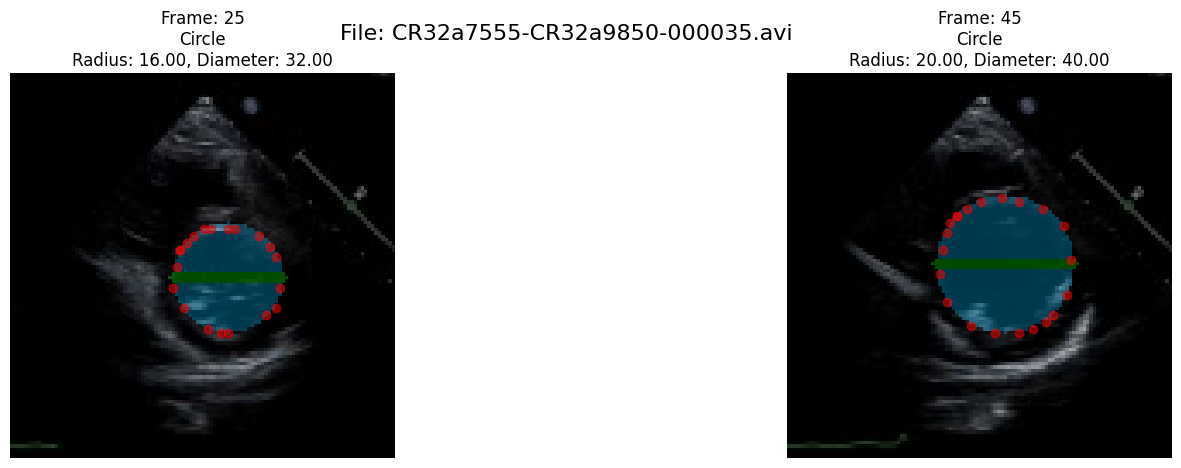

A4C filename: CR32a7555-CR32a9850-000040.avi


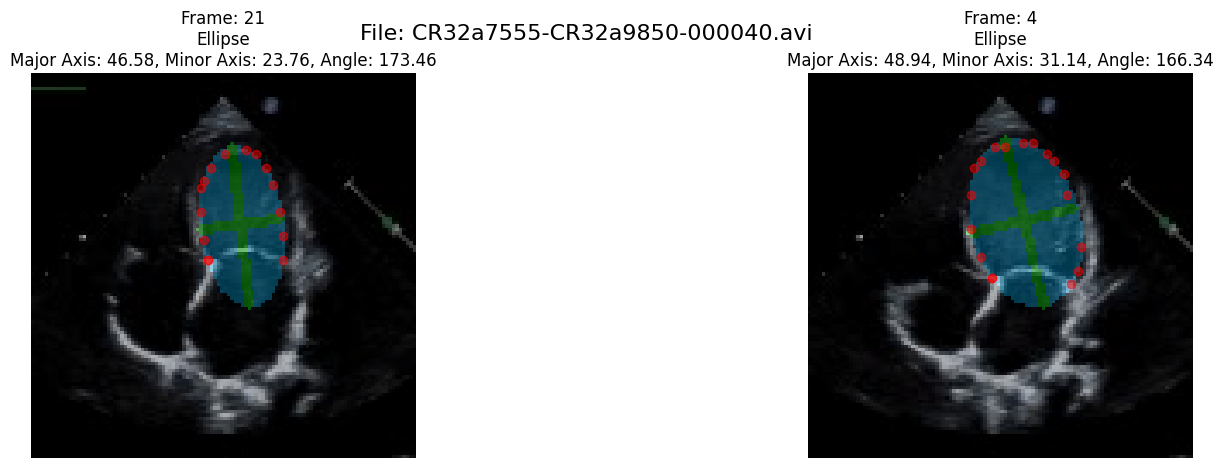

In [11]:
# Pick a patient
patient_id = 4

# Run function to segment the a4c and psax views using volume tracings
extract_filenames_using_patientid(merged_views, patient_id)

# 3D Reconstruction

PSAX filename: CR32a7555-CR32a97e1-000009.avi
End diastolic volume radius: 20
End systolic volume radius: 18
A4C filename: CR32a7555-CR32a97e1-000024.avi
End diastolic volume, major axis: 35.10195541381836
End diastolic volume, minor axis: 24.444929122924805
End systolic volume, major axis: 30.72994613647461
End systolic volume, minor axis: 22.737329483032227


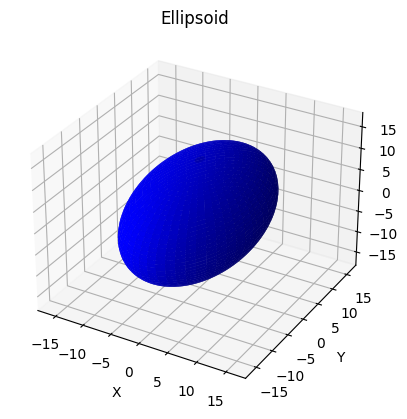

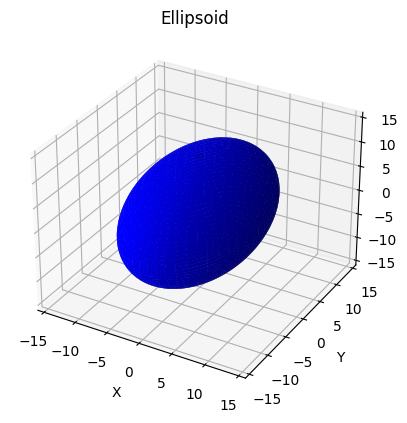

Ejection Fraction: 26.7 %


In [63]:
# Pick a patient from the merged_view csv
patient_id = 3

# Draw ellipsoids from volume tracings
get_filenames_from_merged_views(merged_views,patient_id)

# Calculate Ejection Fraction

In [108]:
# Define function for calculating ejection fraction
total_patients = len(merged_views)

calculate_multiple_ef(merged_views, 1, total_patients)

Predicted EFs
       patient_id  actual_ef  3d_predicted_ef  abs_diff_ef
0              1       40.8             47.9          7.1
1              2       52.6             46.5          6.1
2              3       24.9             26.7          1.9
3              4       51.0             41.9          9.1
4              5       56.8             53.4          3.3
...          ...        ...              ...          ...
3128        3129       59.5             53.3          6.2
3129        3130       59.6             58.4          1.3
3130        3131       60.0             54.0          6.0
3131        3132       59.3             45.8         13.6
3132        3133       59.7             59.2          0.5

[3133 rows x 4 columns]
Mean Squared Error (MSE): 34562281.8
Average Absolute Difference: 216.0


# Old code for reference - do not use

In [13]:
# Ignore this section. Will use this for reference in future.

# Fit ellipsoid
# This is old code that will likely be deprecated. It's plotting both the end diastolic and end systolic views
# Shouldn't be used. Only for reference

def fit_ellipsoid_from_volume_tracings(patient_id):
    # Set df to merged_views
    df = merged_views
    # Extract filenames for a4c and psax views using the patient ID
    filenames_psax = df.loc[df['PatientNumber'] == patient_id, 'FileName_PSAX'].tolist()
    filenames_a4c = df.loc[df['PatientNumber'] == patient_id, 'FileName_A4C'].tolist()

    for psax_filename in filenames_psax:
        # print(f"PSAX filename: {psax_filename}")
        df_psax = psax_volume_tracings[psax_volume_tracings[COLUMN_FILE_NAME] == psax_filename]
        video_psax = read_psax_video(psax_filename)
        x_image1_psax = df_psax[COLUMN_X].values
        y_image1_psax = df_psax[COLUMN_Y].values
        x_y_image1_psax = np.int32(np.array([x_image1_psax, y_image1_psax]).T)

        mask = np.zeros((video_psax.shape[1], video_psax.shape[2], 3), dtype=np.uint8)  # Create empty mask
        ellipse_params_image1_psax = cv2.fitEllipse(x_y_image1_psax)
        cv2.ellipse(mask, ellipse_params_image1_psax, color=(0, 191, 255), thickness=-1)  # Fill the mask with an ellipse

        plt.imshow(mask)
        plt.scatter(x_image1_psax, y_image1_psax, color='r', alpha=0.5)  # Overlay tracing points from psax image
        plt.title(f'PSAX - File: {psax_filename}')
        plt.show()

    for a4c_filename in filenames_a4c:
        print(f"A4C filename: {a4c_filename}")
        df_a4c = a4c_volume_tracings[a4c_volume_tracings[COLUMN_FILE_NAME] == a4c_filename]
        video_a4c = read_a4c_video(a4c_filename)
        x_image1_a4c = df_a4c[COLUMN_X].values
        y_image1_a4c = df_a4c[COLUMN_Y].values
        x_y_image1_a4c = np.int32(np.array([x_image1_a4c, y_image1_a4c]).T)

        mask = np.zeros((video_a4c.shape[1], video_a4c.shape[2], 3), dtype=np.uint8)  # Create empty mask
        ellipse_params_image1_a4c = cv2.fitEllipse(x_y_image1_a4c)
        cv2.ellipse(mask, ellipse_params_image1_a4c, color=(0, 191, 255), thickness=-1)  # Fill the mask with an ellipse

        plt.imshow(mask)
        plt.scatter(x_image1_a4c, y_image1_a4c, color='r', alpha=0.5)  # Overlay tracing points from a4c image
        plt.title(f'A4C - File: {a4c_filename}')
        plt.show()


In [14]:
# Keep this section for now to reference in paper, but this will be ignored

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def calculate_centroid(df):
    # Calculate the centroid of volume tracings (X and Y coordinates)
    x = df['X'].values
    y = df['Y'].values
    centroid_x = np.mean(x)
    centroid_y = np.mean(y)
    return centroid_x, centroid_y

def calculate_z_coordinate(df, longitudinal_position):
    # Calculate the Z-coordinate based on the longitudinal position
    # For this example, let's assume a constant Z value
    z = np.zeros_like(df['X'].values)  # Set all Z values to 0
    return z

def rotate_coordinates(psax_df, rotation_threshold):
    # Rotate the Y coordinates based on the rotation threshold
    y = psax_df['Y'].values
    z = np.where(y <= rotation_threshold, -np.abs(y), np.abs(y))
    return z

def plot_registered_views_3d(end_diastole_df_a4c, end_diastole_df_psax, rotation_threshold=0):
    # Extract X and Y coordinates from A4C view (end diastole)
    x_end_diastole_a4c = end_diastole_df_a4c['X'].values
    y_end_diastole_a4c = end_diastole_df_a4c['Y'].values

    # Extract X and Y coordinates from PSAX view (end diastole)
    x_end_diastole_psax = end_diastole_df_psax['X'].values
    y_end_diastole_psax = end_diastole_df_psax['Y'].values

    # Calculate the centroids of A4C view's end diastole volume tracings
    centroid_a4c_x, centroid_a4c_y = calculate_centroid(end_diastole_df_a4c)

    # Calculate the centroids of PSAX view's end diastole volume tracings
    centroid_psax_x, centroid_psax_y = calculate_centroid(end_diastole_df_psax)

    # Calculate the translation vectors to align the centroids of both views
    translation_vector_x = centroid_a4c_x - centroid_psax_x
    translation_vector_y = centroid_a4c_y - centroid_psax_y

    # Apply the translation vectors to the PSAX view's end diastole volume tracings
    x_end_diastole_psax_registered = x_end_diastole_psax + translation_vector_x
    y_end_diastole_psax_registered = y_end_diastole_psax + translation_vector_y

    # Calculate the synthetic Z-coordinate based on the longitudinal position
    longitudinal_position_psax = 0.5  # Adjust the longitudinal position as needed
    z_end_diastole_psax_registered = calculate_z_coordinate(end_diastole_df_psax, longitudinal_position_psax)

    # Rotate the Z coordinates based on the rotation threshold
    z_end_diastole_psax_registered = rotate_coordinates(end_diastole_df_psax, rotation_threshold)

    # Plot the registered A4C and PSAX views
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_end_diastole_a4c, y_end_diastole_a4c, np.zeros_like(x_end_diastole_a4c), c='blue', label='A4C')
    ax.scatter(x_end_diastole_psax_registered, y_end_diastole_psax_registered,
               z_end_diastole_psax_registered, c='red', label='PSAX (Registered)')
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Registered Views (End Diastole)')
    plt.show()

# Below is the old code I was using when I was trying to manually rotate the two views. This section will likely be deprecated later
# in favor of using the calculated parameters from the cross-sections.

# psax_edv, psax_esv = get_psax_volume_tracings(psax)
# a4c_edv, a4c_esv = get_a4c_volume_tracings(a4c)

# plot_registered_views(a4c_edv,psax_edv)

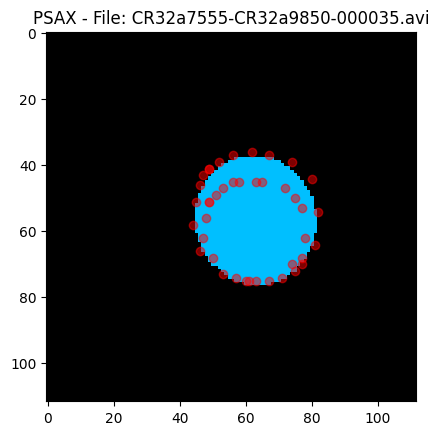

A4C filename: CR32a7555-CR32a9850-000040.avi


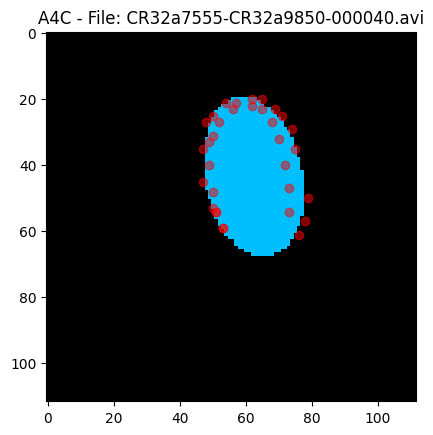

In [15]:
fit_ellipsoid_from_volume_tracings(4)

In [16]:
# This section can be ignored

# Test volume tracings function
#a4c = 'CR32a7555-CR32a9850-000040.avi'
#psax = 'CR32a7555-CR32a9850-000035.avi'

# Use the below to validate that the volume tracings for
# 1) There are two frames per video, one representing end diastolic volume and another representing end systolic volume
# 2) We are able to temporally register them by checking the area. The functions contain commented out code that checks it.


# This is the code to check
# get_a4c_volume_tracings(a4c)
# get_psax_volume_tracings(psax)